<a href="https://colab.research.google.com/github/orenshor/eCommerce_project/blob/master/task_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import Embedding, Input, Dense, Flatten, Dropout
from keras.optimizers import Adam, Adamax
from keras.layers import Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
RATING_DATA_TEST_FILE = "u1.test"
RATING_DATA_TRAIN_FILE = "u1.base"
MODEL_WEIGHTS_FILE = "u_emb_weights.h5"

USER_DATA_FILE = 'u.user'
MODEL_WEIGHTS_FILE_CORE = 'u_emb_weights'

In [4]:
#import of the data

user_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
movie_cols = ['user_id','movie_id','rating','timestamp']

# load users data
user_data = pd.read_csv(USER_DATA_FILE, sep='|', engine='python', encoding='latin-1', names=user_cols)

# replace values in the data
user_data['gender'].replace(['F','M'],['0','1'],inplace=True)
user_data['age'] = pd.cut(user_data['age'],bins=[0,18,25,30,40,50,100], labels=["0","1","2","3","4","5"])

# load movies data
ratings_train = pd.read_csv(RATING_DATA_TRAIN_FILE, sep='\t', engine='python', encoding='latin-1', names=movie_cols)

# marge users info and ratings 
ratings_train = pd.merge(ratings_train, user_data, on='user_id',how='inner')
print(ratings_train.head())
# train
max_userid = ratings_train['user_id'].drop_duplicates().max()
max_movieid = ratings_train['movie_id'].drop_duplicates().max()
ratings_train['user_emb_id'] = ratings_train['user_id'] - 1
ratings_train['movie_emb_id'] = ratings_train['movie_id'] - 1
print(str(len(ratings_train))+' ratings loaded from train')

# test
ratings_test = pd.read_csv(RATING_DATA_TEST_FILE, sep='\t',   engine='python', encoding='latin-1',  names=movie_cols)
ratings_test = pd.merge(ratings_test, user_data, on='user_id', how='inner')
print(ratings_test.head())
ratings_test['user_emb_id'] = ratings_test['user_id'] - 1
ratings_test['movie_emb_id'] = ratings_test['movie_id'] - 1
print(str(len(ratings_test))+' ratings loaded from test')



   user_id  movie_id  rating  timestamp age gender  occupation zip_code
0        1         1       5  874965758   1      1  technician    85711
1        1         2       3  876893171   1      1  technician    85711
2        1         3       4  878542960   1      1  technician    85711
3        1         4       3  876893119   1      1  technician    85711
4        1         5       3  889751712   1      1  technician    85711
80000 ratings loaded from train
   user_id  movie_id  rating  timestamp age gender  occupation zip_code
0        1         6       5  887431973   1      1  technician    85711
1        1        10       3  875693118   1      1  technician    85711
2        1        12       5  878542960   1      1  technician    85711
3        1        14       5  874965706   1      1  technician    85711
4        1        17       3  875073198   1      1  technician    85711
20000 ratings loaded from test


In [0]:
# train values
train_users = ratings_train['user_emb_id'].values
train_movies = ratings_train['movie_emb_id'].values
train_ratings = ratings_train['rating'].values
train_gender = ratings_train['gender'].values
train_age = ratings_train['age'].values

Test_Users = ratings_test['user_emb_id'].values
Test_Movies = ratings_test['movie_emb_id'].values
Test_Ratings = ratings_test['rating'].values

In [0]:
# model from ex. 4 with adjustments
def get_ncf_model_gen1(num_users, num_items, latent_dim, hidden_dim,do):
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    gender_input = Input(shape=(1,), dtype='float32', name = 'gender_input')
    age_input = Input(shape=(1,), dtype='float32', name = 'age_input')

    NCF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding', input_length=1)
    NCF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding', input_length=1)   
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(NCF_Embedding_User(user_input))
    item_latent = Flatten()(NCF_Embedding_Item(item_input))
    
    # Concat user and item embeddings with gender
    conc = Concatenate()([user_latent, item_latent, gender_input, age_input])
    drop = Dropout(do)(conc)
    hid1 = Dense(hidden_dim, activation='relu')(conc)
    drop2  = Dropout(do)(hid1)
    prediction = Dense(1, activation='relu', kernel_initializer='lecun_uniform', name = 'prediction')(drop2)
    
    model = Model(inputs=[user_input, item_input, gender_input, age_input], outputs=prediction)
    print("ncf model gender 1")
    model.summary()

    return model

In [0]:
def save_model(model, model_name):
    model_json = model.to_json()
    with open(model_name + ".json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights(model_name + ".h5")
from keras.engine.saving import model_from_json
def load_model(model_name):
    json_file = open(model_name + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(model_name + ".h5")
    return loaded_model

In [33]:
K_LATENT = 20
hidden_dim = 20
do = 0.3

NCF_G_model1 = get_ncf_model_gen1(max_userid, max_movieid, K_LATENT,hidden_dim, do)
NCF_G_model1.compile(loss='mse',optimizer=Adamax(),metrics=['mae'])

ncf model gender 1
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 20)        18860       user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 20)        33640       item_input[0][0]                 
_________________________________________________________________________

In [42]:
callbacks_ncfg1 = [EarlyStopping('val_loss', patience=20), 
             ModelCheckpoint(MODEL_WEIGHTS_FILE_CORE + '_ncfg_' + str(do) + '_' + str(K_LATENT) + '.h5', save_best_only=True)]
history_ncfg1 = NCF_G_model1.fit([train_users, train_movies, train_gender, train_age], train_ratings,
                                 epochs=30, validation_split=0.1, verbose=1, callbacks=callbacks_ncfg1, batch_size = 32)
save_model(NCF_G_model1, "task5_model1")

Train on 72000 samples, validate on 8000 samples
Epoch 1/30
72000/72000 [==============================] - 4s 51us/step - loss: 0.7795 - mae: 0.6929 - val_loss: 1.0694 - val_mae: 0.8594
Epoch 2/30
72000/72000 [==============================] - 4s 51us/step - loss: 0.7758 - mae: 0.6908 - val_loss: 1.0607 - val_mae: 0.8554
Epoch 3/30
72000/72000 [==============================] - 4s 51us/step - loss: 0.7739 - mae: 0.6901 - val_loss: 1.0559 - val_mae: 0.8526
Epoch 4/30
72000/72000 [==============================] - 4s 50us/step - loss: 0.7699 - mae: 0.6880 - val_loss: 1.0723 - val_mae: 0.8612
Epoch 5/30
72000/72000 [==============================] - 4s 52us/step - loss: 0.7705 - mae: 0.6891 - val_loss: 1.0594 - val_mae: 0.8532
Epoch 6/30
72000/72000 [==============================] - 4s 51us/step - loss: 0.7693 - mae: 0.6878 - val_loss: 1.0608 - val_mae: 0.8556
Epoch 7/30
72000/72000 [==============================] - 4s 51us/step - loss: 0.7668 - mae: 0.6871 - val_loss: 1.0586 - val_mae:

In [0]:
# model_task5 = load_model("task5_model1")


MAE = 0.84571015625


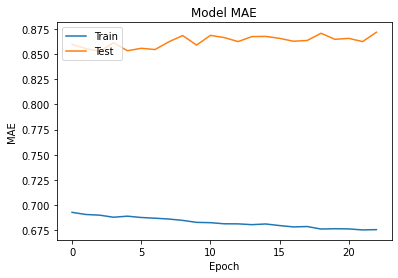

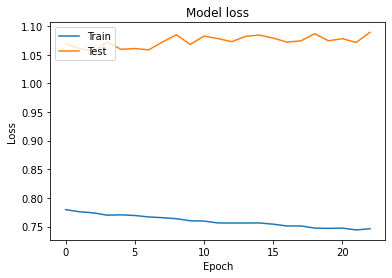

In [43]:
# test values
test_users = ratings_test['user_emb_id'].values
test_movies = ratings_test['movie_emb_id'].values
test_ratings = ratings_test['rating'].values
test_gender = ratings_test['gender'].values
test_age = ratings_test['age'].values

preddict_model_gen1 = NCF_G_model1.predict([test_users,test_movies, test_gender, test_age])
test_predict1 = pd.DataFrame(data=preddict_model_gen1, columns=['prediction'])
test_predict1['actual_rating'] = test_ratings

MAE1 = np.sum(abs(test_predict1['actual_rating']-test_predict1['prediction']))/test_predict1.shape[0]
print("MAE = "+ str(MAE1))

visual_results(history_ncfg1)

In [0]:
pip install deepctr[gpu]

In [0]:
from deepctr.models import DeepFM
from deepctr.inputs import SparseFeat, get_feature_names
from sklearn.preprocessing import LabelEncoder

In [10]:
for feat in ['user_emb_id','movie_emb_id', 'gender', 'age']:
        lbe = LabelEncoder()
        ratings_train[feat] = lbe.fit_transform(ratings_train[feat])


for feat in ['user_emb_id','movie_emb_id', 'gender', 'age']:
        lbe = LabelEncoder()
        ratings_test[feat] = lbe.fit_transform(ratings_test[feat])


fixlen_feature_columns = [SparseFeat(feat, ratings_train[feat].nunique(), embedding_dim=20)
                              for feat in ['user_emb_id','movie_emb_id', 'gender', 'age']]
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)
print(feature_names)


model_deepFM = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression')
model_deepFM.compile("adam", "mse", metrics=['mae'])

train_model_deepFM_input = {name: ratings_train[name].values for name in feature_names}

test_model_deepFM_input = {name: ratings_test[name].values for name in feature_names}

history = model_deepFM.fit(train_model_deepFM_input, train_ratings, epochs=30,  verbose=1, validation_split=0.1, batch_size = 1)

['user_emb_id', 'movie_emb_id', 'gender', 'age']
Epoch 1/30


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


72000/72000 [==============================] - 162s 2ms/step - loss: 1.0091 - mae: 0.7970 - val_loss: 0.9776 - val_mae: 0.7931
Epoch 2/30
72000/72000 [==============================] - 160s 2ms/step - loss: 0.8946 - mae: 0.7408 - val_loss: 1.0196 - val_mae: 0.8186
Epoch 3/30
72000/72000 [==============================] - 163s 2ms/step - loss: 0.8301 - mae: 0.7044 - val_loss: 1.0537 - val_mae: 0.8321
Epoch 4/30
72000/72000 [==============================] - 165s 2ms/step - loss: 0.7857 - mae: 0.6793 - val_loss: 1.1223 - val_mae: 0.8644
Epoch 5/30
72000/72000 [==============================] - 164s 2ms/step - loss: 0.7526 - mae: 0.6596 - val_loss: 1.1394 - val_mae: 0.8685
Epoch 6/30
72000/72000 [==============================] - 162s 2ms/step - loss: 0.7369 - mae: 0.6482 - val_loss: 1.1207 - val_mae: 0.8579
Epoch 7/30
72000/72000 [==============================] - 165s 2ms/step - loss: 0.7226 - mae: 0.6400 - val_loss: 1.0936 - val_mae: 0.8450
Epoch 8/30
72000/72000 [=====================

NameError: ignored

In [41]:
model_deepFM.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_emb_id (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_emb_id (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
gender (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
age (InputLayer)                [(None, 1)]          0                                            
______________________________________________________________________________________________

In [0]:
save_model(model_deepFM, "task5_deepFM")

In [0]:
def visual_results(history):
  plt.plot(history.history['mae'])
  plt.plot(history.history['val_mae'])
  plt.title('Model MAE')
  plt.ylabel('MAE')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

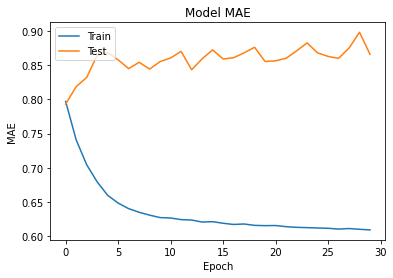

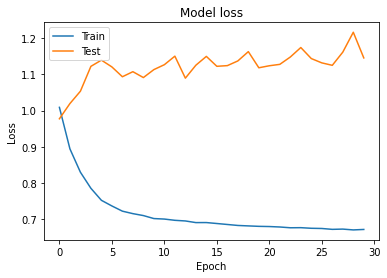


MAE deepFM = 0.860973046875


In [24]:
visual_results(history)
pred_deepFM = model_deepFM.predict(test_model_deepFM_input)
test_predict_deepFM = pd.DataFrame(data=pred_deepFM, columns=['prediction'])
test_predict_deepFM['actual_rating'] = test_ratings
MAE_deepFM = np.sum(abs(test_predict_deepFM['actual_rating']-test_predict_deepFM['prediction']))/test_predict_deepFM.shape[0]
# save_model(model_deepFM, "task5_deepFM")
print()
print("MAE deepFM = " + str(MAE_deepFM))